In [1]:
import numpy as np
import pandas as pd

import cv2
from pathlib import Path

import matplotlib.pyplot as plt

from tqdm import tqdm
from skimage.feature import local_binary_pattern, graycomatrix, graycoprops
from sklearn.preprocessing import LabelEncoder

import os, glob, random



In [29]:
def get_rgb(path):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def get_hsv(path):
    img = cv2.imread(path)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    return hsv

def get_gray(path):
    img = cv2.imread(path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return gray

def get_green_coverage(img_):
    green_mask = (img_[:, :, 1] > img_[:, :, 0]) & (img_[:, :, 1] > img_[:, :, 2])
    return green_mask.sum() / green_mask.size

def get_sobel(gray_, ksize = 3):
    sobelx  = cv2.Sobel(gray_, cv2.CV_64F, 1, 0, ksize=ksize)
    sobely  = cv2.Sobel(gray_, cv2.CV_64F, 0, 1, ksize=ksize)
    return np.sqrt(sobelx**2 + sobely**2)

def get_canny(gray_, low_threshold = 100, high_threshold = 200): 
    return cv2.Canny(gray_, low_threshold, high_threshold) 
    
def get_binary(gray, threshold = 127):
    _, binary = cv2.threshold(gray, threshold, 255, cv2.THRESH_BINARY)
    return binary 
 
def get_lbp(gray_, p = 8, r = 3, method = "uniform"):
    return local_binary_pattern(gray_, P=p, R=r, method=method)

def resized_img(img): 
    return cv2.resize(img, (256, 256))
    
def get_contours(binary):
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return contours

def get_glcm(gray_, distance = 1, angle = [0, np.pi/4, np.pi/2, 3*np.pi/4], levels = 256, symmetric = True, normed = True):
    return graycomatrix(gray_, distances=[distance], angles=angle, levels=levels, symmetric=symmetric, normed=normed)

def get_glcm_prop(gray_):
    glcm = get_glcm(gray_)
    
    features = {}

    features['contrast']      = graycoprops(glcm, 'contrast').mean()
    features['dissimilarity'] = graycoprops(glcm, 'dissimilarity').mean()
    features['homogeneity']   = graycoprops(glcm, 'homogeneity').mean()
    features['energy']        = graycoprops(glcm, 'energy').mean()
    features['glcm_corre']    = graycoprops(glcm, 'correlation').mean()
    features['ASM']           = graycoprops(glcm, 'ASM').mean()
    features['entropy']       = graycoprops(glcm, 'entropy').mean()

    return features


In [30]:
def update_features(path_):

    all_features = {}

    all_features.update(get_rgb_hsv_features(path_))
    all_features.update(get_texture_features(path_))
    all_features.update(get_glcm_features(path_))

    return all_features

def get_rgb_hsv_features(path_):
    features = {}

    rgb_img = get_rgb(path_)
    hsv_img = get_hsv(path_)

    for i , channel in enumerate(['r', 'g', 'b']):
        features[f'{channel}_mean']     = rgb_img[:, :, i].mean()
        features[f'{channel}_median']   = np.median(rgb_img[:, :, i])
        features[f'{channel}_std']      = rgb_img[:, :, i].std()
    
    features['green_coverage'] = get_green_coverage(rgb_img); del rgb_img

    for i , channel in enumerate(['hue', 'sat', 'val']):
        features[f'{channel}_mean']     = hsv_img[:, :, i].mean()
        features[f'{channel}_std']      = hsv_img[:, :, i].std()
    
    del hsv_img    
    return features     

def get_texture_features(path_):
    features = {}

    gray_img    = get_gray(path_)
    sobel_img   = get_sobel(gray_img)
    canny_img   = get_canny(gray_img)
    binary_img  = get_binary(gray_img)
    lbp_img     = get_lbp(resized_img(gray_img))

    features['sobel_mean']  = sobel_img.mean()
    features['sobel_std']   = sobel_img.std(); del sobel_img

    features['canny_mean']  = canny_img.mean()
    features['canny_std']   = canny_img.std(); del canny_img

    features['binary_mean'] = binary_img.mean()
    features['binary_std']  = binary_img.std(); del binary_img
 
    features['lbp_mean']    = lbp_img.mean()
    features['lbp_std']     = lbp_img.std() 

    nbins       = int(np.unique(lbp_img.ravel()).max()) +1 
    lbp_hist, _ = np.histogram(lbp_img.ravel(), bins=nbins, range=(0, nbins), density=True) ; del lbp_img
    lbp_list    = lbp_hist/lbp_hist.sum() 
    for i, vals in enumerate(lbp_list):
        features[f'lbp_{i}'] = vals

    return features

def get_glcm_features(path_):
    gray_img = get_gray(path_) 
    features = get_glcm_prop(resized_img(gray_img))

    return features



In [31]:
project_path = "/Users/k.choi/Documents/github/csiro_git"
data_path   = os.path.join(project_path, "data")
img_path    = os.path.join(data_path, "train")
img_list    = glob.glob(os.path.join(img_path, "*.jpg"))
train_df    = pd.read_csv(os.path.join(data_path, "train.csv"))
train_df['image_id'] = train_df['image_path'].apply(lambda x: Path(x).stem)

print('project_path : ', project_path)
print('data_path : ', data_path)
print('img_path : ', img_path)
print('total number of images : ', len(img_list))
print('train_df : ', train_df.info())

project_path :  /Users/k.choi/Documents/github/csiro_git
data_path :  /Users/k.choi/Documents/github/csiro_git/data
img_path :  /Users/k.choi/Documents/github/csiro_git/data/train
total number of images :  357
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1785 entries, 0 to 1784
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   sample_id      1785 non-null   object 
 1   image_path     1785 non-null   object 
 2   Sampling_Date  1785 non-null   object 
 3   State          1785 non-null   object 
 4   Species        1785 non-null   object 
 5   Pre_GSHH_NDVI  1785 non-null   float64
 6   Height_Ave_cm  1785 non-null   float64
 7   target_name    1785 non-null   object 
 8   target         1785 non-null   float64
 9   image_id       1785 non-null   object 
dtypes: float64(3), object(7)
memory usage: 139.6+ KB
train_df :  None


/Users/k.choi/Documents/github/csiro_git/data/train/ID605134229.jpg


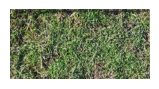

/Users/k.choi/Documents/github/csiro_git/data/train/ID1789834546.jpg


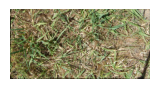

/Users/k.choi/Documents/github/csiro_git/data/train/ID1471216911.jpg


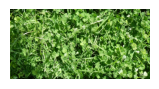

In [32]:
selected_img_path = random.sample(img_list, 100)

for img_path in selected_img_path[:3]:
    print(img_path); plt.figure(figsize=(3, 1))
    rgb_img = get_rgb(img_path)
    plt.imshow(rgb_img); plt.axis('off'); plt.tight_layout(); plt.show()

In [33]:
%%time 

features_list = []

# for img_path in tqdm(selected_img_path, desc='features extraction in progress'):
for img_path in tqdm(img_list, desc='features extraction in progress'):

    try:
        features = update_features(img_path)
    
        features['image_id'] = Path(img_path).stem
        features_list.append(features)

    except Exception as e:
        print(f"Error loading {img_path}: {e}")
        continue

features_df = pd.DataFrame(features_list)
# cols = ['image_id'] + [ col for col in features_df.columns if col != 'image_id' ]
# features_df = features_df[cols]




features extraction in progress: 100%|██████████| 357/357 [01:23<00:00,  4.29it/s]

CPU times: user 1min 24s, sys: 9.58 s, total: 1min 34s
Wall time: 1min 23s


In [34]:
%%time

metadata_df = train_df.groupby('image_id').first()[['Sampling_Date', 'State', 'Species', 'Pre_GSHH_NDVI', 'Height_Ave_cm']].reset_index()
metadata_df = pd.merge(features_df, metadata_df, on='image_id', how='left')

metadata_df.info()
metadata_df.to_csv(os.path.join(project_path + '/stats', "metadata_df.csv"), index=False)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 47 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   r_mean          357 non-null    float64
 1   r_median        357 non-null    float64
 2   r_std           357 non-null    float64
 3   g_mean          357 non-null    float64
 4   g_median        357 non-null    float64
 5   g_std           357 non-null    float64
 6   b_mean          357 non-null    float64
 7   b_median        357 non-null    float64
 8   b_std           357 non-null    float64
 9   green_coverage  357 non-null    float64
 10  hue_mean        357 non-null    float64
 11  hue_std         357 non-null    float64
 12  sat_mean        357 non-null    float64
 13  sat_std         357 non-null    float64
 14  val_mean        357 non-null    float64
 15  val_std         357 non-null    float64
 16  sobel_mean      357 non-null    float64
 17  sobel_std       357 non-null    flo

In [35]:
dry_df      = train_df[train_df['target_name'] == 'Dry_Total_g'][['image_id', 'target']].copy(); print(len(dry_df))
green_df    = train_df[train_df['target_name'] == 'Dry_Green_g'][['image_id', 'target']].copy(); print(len(green_df))
dead_df     = train_df[train_df['target_name'] == 'Dry_Dead_g'][['image_id', 'target']].copy(); print(len(dead_df))
clover_df   = train_df[train_df['target_name'] == 'Dry_Clover_g'][['image_id', 'target']].copy(); print(len(clover_df))
gdm_df      = train_df[train_df['target_name'] == 'GDM_g'][['image_id', 'target']].copy(); print(len(gdm_df))


dry_df      = dry_df.rename(columns={'target': 'Dry_Total_g'})
green_df    = green_df.rename(columns={'target': 'Dry_Green_g'})
dead_df     = dead_df.rename(columns={'target': 'Dry_Dead_g'})
clover_df   = clover_df.rename(columns={'target': 'Dry_Clover_g'})
gdm_df      = gdm_df.rename(columns={'target': 'GDM_g'})

complete_df = pd.merge(metadata_df, dry_df, on='image_id')
complete_df = pd.merge(complete_df, green_df, on='image_id')
complete_df = pd.merge(complete_df, dead_df, on='image_id')
complete_df = pd.merge(complete_df, clover_df, on='image_id')
complete_df = pd.merge(complete_df, gdm_df, on='image_id')

print(complete_df.columns)
print(complete_df.info())

complete_df.to_csv(os.path.join(project_path + '/stats', "complete_df.csv"), index=False)


357
357
357
357
357
Index(['r_mean', 'r_median', 'r_std', 'g_mean', 'g_median', 'g_std', 'b_mean',
       'b_median', 'b_std', 'green_coverage', 'hue_mean', 'hue_std',
       'sat_mean', 'sat_std', 'val_mean', 'val_std', 'sobel_mean', 'sobel_std',
       'canny_mean', 'canny_std', 'binary_mean', 'binary_std', 'lbp_mean',
       'lbp_std', 'lbp_0', 'lbp_1', 'lbp_2', 'lbp_3', 'lbp_4', 'lbp_5',
       'lbp_6', 'lbp_7', 'lbp_8', 'lbp_9', 'contrast', 'dissimilarity',
       'homogeneity', 'energy', 'glcm_corre', 'ASM', 'entropy', 'image_id',
       'Sampling_Date', 'State', 'Species', 'Pre_GSHH_NDVI', 'Height_Ave_cm',
       'Dry_Total_g', 'Dry_Green_g', 'Dry_Dead_g', 'Dry_Clover_g', 'GDM_g'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 52 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   r_mean          357 non-null    float64
 1   r_median        357 non-null    flo

In [37]:
species_encoder = LabelEncoder()
state_encoder   = LabelEncoder()


analysis_df             = complete_df.copy()

analysis_df['Species']  = species_encoder.fit_transform(analysis_df['Species'])
analysis_df['State']    = state_encoder.fit_transform(analysis_df['State'])

print('Species:')
for i in np.unique(analysis_df['Species']): print(i, species_encoder.inverse_transform([i]) )
print('State:')
for i in np.unique(analysis_df['State']): print(i, state_encoder.inverse_transform([i]) )


analysis_df             = analysis_df.drop(columns=['Sampling_Date', 'image_id'])



Species:
0 ['Clover']
1 ['Fescue']
2 ['Fescue_CrumbWeed']
3 ['Lucerne']
4 ['Mixed']
5 ['Phalaris']
6 ['Phalaris_BarleyGrass_SilverGrass_SpearGrass_Clover_Capeweed']
7 ['Phalaris_Clover']
8 ['Phalaris_Clover_Ryegrass_Barleygrass_Bromegrass']
9 ['Phalaris_Ryegrass_Clover']
10 ['Ryegrass']
11 ['Ryegrass_Clover']
12 ['SubcloverDalkeith']
13 ['SubcloverLosa']
14 ['WhiteClover']
State:
0 ['NSW']
1 ['Tas']
2 ['Vic']
3 ['WA']


In [38]:
correlation_dry_clov  =  analysis_df.corr()['Dry_Clover_g'].sort_values(ascending=False)
correlation_dry_gdm   =  analysis_df.corr()['GDM_g'].sort_values(ascending=False)
correlation_dry_dead  =  analysis_df.corr()['Dry_Dead_g'].sort_values(ascending=False)
correlation_dry_green =  analysis_df.corr()['Dry_Green_g'].sort_values(ascending=False)
correlation_dry_total =  analysis_df.corr()['Dry_Total_g'].sort_values(ascending=False)


In [39]:
## drop target features
correlation = correlation_dry_total.drop(['Dry_Total_g', 'Dry_Clover_g', 'Dry_Dead_g', 'Dry_Green_g', 'GDM_g'])

In [40]:
# highest correlated features
print('positively correlated')
print(correlation.head(10))

# lowest correlated features
print('negatively correlated')
print(correlation.tail(10))

positively correlated
Height_Ave_cm     0.497226
lbp_6             0.445617
Pre_GSHH_NDVI     0.361291
lbp_5             0.354237
green_coverage    0.329020
sat_mean          0.304878
lbp_4             0.297700
glcm_corre        0.296380
sat_std           0.278425
homogeneity       0.266622
Name: Dry_Total_g, dtype: float64
negatively correlated
Species      -0.269073
b_median     -0.271241
lbp_8        -0.280055
lbp_std      -0.299924
hue_std      -0.306173
canny_std    -0.318791
lbp_mean     -0.344543
State        -0.347690
canny_mean   -0.353240
lbp_9        -0.377913
Name: Dry_Total_g, dtype: float64


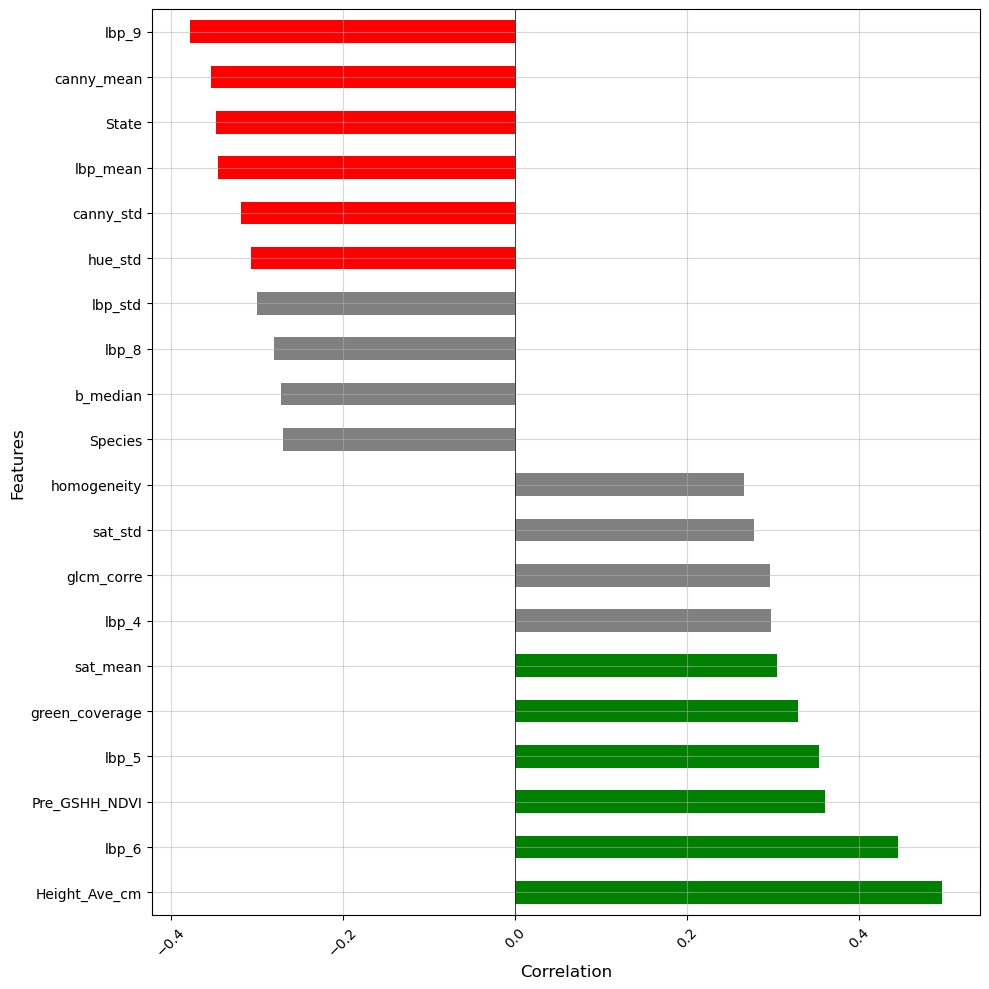

In [41]:
relevant_features = pd.concat([correlation.head(10), correlation.tail(10)])
plt.figure( figsize = (10, 10))

colors = ['green' if (x > 0.3) else 'red' if (x < -0.3) else 'gray' for x in relevant_features]

relevant_features.plot(kind='barh', color=colors)
plt.axvline(x=0, color='black', linewidth=0.5)
plt.xlabel('Correlation', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.grid(True, alpha = 0.5)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


0.4504551469209866
0.4264868720657177
0.3388782043202315
0.3170628016068585
0.31165690795684337
0.2664978132589556
0.2521229645482008
0.25149383201177455
0.2472327964902857
0.23976359153092103
-0.18170710147815627
-0.2257093626864863
-0.2340284985525969
-0.24431379979058013
-0.2598244646574742
-0.2645700822491552
-0.2666422908117065
-0.2783042213797944
-0.3395324684649885
-0.3475623554662108
